In [367]:
import numpy as np
import requests
import pyprind
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
import pandas as pd
%matplotlib inline

In [368]:
# load all words vocabulary. All these words should be classified as positive samples.
positives = [w.lower() for w in np.genfromtxt('words.txt', dtype=np.str, delimiter='\n\r')]

In [369]:
positives[0:10]

['a', "a'asia", "a's", 'aa', "aa's", 'aaa', 'aaaa', 'aaaaaa', 'aaal', 'aaas']

In [370]:
def collectTrainData(samples=100):
    seeds = np.random.uniform(0, 1919415150, samples)
    bar = pyprind.ProgBar(samples, bar_char='█')
    dump = {}
    for seed in seeds:
        r = requests.get('https://hola.org/challenges/word_classifier/testcase/%d'%seed)
        json = r.json()
        dump.update(json)
        bar.update()
    return dump

In [371]:
def saveTrainData(dump):
    with open('train.txt', 'wb') as file:
        pickle.dump(dump, file)

def loadTrainData():
    with open('train.txt', 'rb') as file:
        return pickle.loads(file.read())

In [372]:
train = collectTrainData()
saveTrainData(train)

0%                          100%
[██████████████████████████████] | ETA: 00:00:00
Total time elapsed: 00:00:19


In [373]:
train = loadTrainData()

In [374]:
[(key, train[key]) for key in train.keys()][:5]

[('anthropotheist', True),
 ('caballing', True),
 ('immunologist', True),
 ('vaconornaggiaticraters', False),
 ('mishings', False)]

In [375]:
def validate(classifier, train):
    predicted = [classifier(sample) == train[sample] for sample in train]
    return np.sum(predicted)/len(train), predicted

In [376]:
chars = []
for w in positives:
    for c in list(w):
        chars.append(c)

In [377]:
chars_hist = {None: len(positives)}
for c in chars:
    if c in chars_hist:
        chars_hist[c] += 1
    else:
        chars_hist[c] = 0

In [378]:
charProbs = {c: np.log(1 + chars_hist[c]/sum(chars_hist.values())) for c in chars_hist}

In [379]:
def getCharPairs(word):
    return list(zip([None] + list(word), list(word)))

charPairsHist = {}

for w in positives:
    for p in getCharPairs(w):
        if p in charPairsHist:
            charPairsHist[p] += 1
        else:
            charPairsHist[p] = 0

for c in np.unique([list(w)[0] for w in positives]):
    charPairsHist[(None, c)] = len([w for w in positives if list(w)[0] == c])
    
for c in np.unique([list(w)[len(w) - 1] for w in positives]):
    charPairsHist[(c, None)] = len([w for w in positives if list(w)[len(w) - 1] == c])

In [382]:
charPairsHist[(None, 'a')], charPairsHist[('a', None)]

(44922, 26851)

In [381]:
charCondProbs = {(c1, c2): np.log(1 + charPairsHist[(c1, c2)]/chars_hist[c1]) for (c1, c2) in charPairsHist}

In [ ]:
def getWordProb(word):
    prob = 0
    for c1, c2 in list(zip([None] + list(word), list(word) + [None])):
        if not c2 in charProbs:
            return 0
        if not (c1, c2) in charCondProbs:
            return 0
        prob += (charCondProbs[(c1, c2)] if (c1, c2) in charCondProbs else 0)
    return prob

In [384]:
getWordProb('a'), charCondProbs[(None, 'a')], charProbs['a']

(0.11498718242369202, 0.065684933513879801, 0.074109864701684403)

In [385]:
x = np.linspace(0, 1, num=20)
accuracy =  [validate(lambda w: getWordProb(w) > t, train)[0] for t in x]

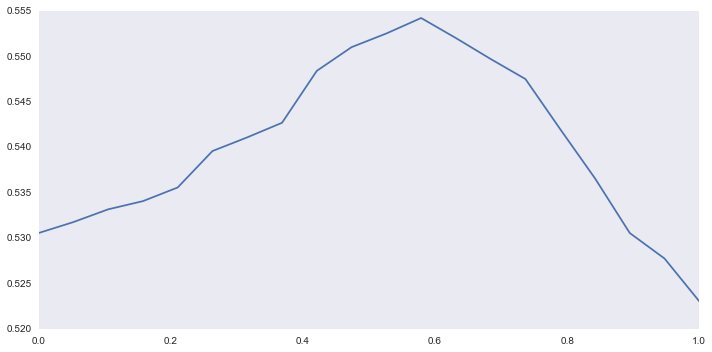

In [386]:
plt.figure(figsize=(10, 5))
plt.plot(x, accuracy)
plt.tight_layout()
plt.grid()

In [388]:
predicted = pd.Series(validate(lambda w: getWordProb(w) > 0.55, train)[1])
actual = pd.Series(list(train.values()))
pd.crosstab(actual, predicted)

col_0,False,True
row_0,,
False,4042,901
True,396,4630
